<a href="https://colab.research.google.com/github/insaiyancvk/speedyblackman/blob/main/speedy_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Starting with Left/Right work

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# from IPython.display import Image
!pip install -q python-telegram-bot

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os, telegram, json, cv2, time, random, zipfile
from PIL import Image

import torch
import torchvision

from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision.models.resnet import resnet18
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"{device} activated.")

cuda activated.


In [ ]:
print("Initializing kaggle")
!rm -rf /root/.kaggle && mkdir /root/.kaggle && cp /content/drive/MyDrive/kaggle.json . && mv kaggle.json /root/.kaggle/kaggle.json

print("Downloading the dataset")
!kaggle datasets download insaiyancvk/nfs-rivals-left-and-right-turn-data

print("Extracting the dataset")
with zipfile.ZipFile("nfs-rivals-left-and-right-turn-data.zip") as zf:
  for member in tqdm(zf.infolist(), desc='Extracting'):
    try:
      zf.extract(member, "/content")
    except zipfile.error:
      pass
!rm nfs-rivals-left-and-right-turn-data.zip

Initializing kaggle
100% 6.86G/6.88G [02:12<00:00, 56.8MB/s]
100% 6.88G/6.88G [02:12<00:00, 55.7MB/s]
Extracting the dataset


Extracting:   0%|          | 0/34916 [00:00<?, ?it/s]

In [ ]:
#@title Telegram bot
class send(): 

  def __init__(self):
    f = open ('/content/drive/MyDrive/tel.json', 'r')
    self.tel = json.load(f)
    f.close()
    self.bot = telegram.Bot(token=self.tel['token']) 

  def msg(self, mesg):
    self.bot.sendMessage(chat_id=self.tel['nnboiid'], text=mesg)

  def pic(self, path):
    self.bot.sendPhoto(chat_id=self.tel['nnboiid'], photo=open(path, 'rb'))
bot = send()

### Defining some constants

In [ ]:
#@title
print("Initializing classes")

class_list = [
              'a',
              'd']

print("Creating workspace")

drive = os.path.join("drive","MyDrive")
FOLDERS = {
    "TRAIN": os.path.join("set2","train"),
    "TEST": os.path.join("set2","test"),
    "WORKSPACE": os.path.join(drive,"speedata","workspace"),
    "MODELS": os.path.join(drive,"speedata","workspace","models"),
    "PERFORMANCE": os.path.join(drive,"speedata","workspace","performance")
}

for key in FOLDERS:
  if not os.path.isdir(FOLDERS[key]):
    print(key, "directory doesn't exist. Creating one.")
    os.mkdir(FOLDERS[key])
    print(key, "directory created.")

Initializing classes
Creating workspace


In [ ]:
SPLIT_FOLDERS = {
    'TRAIN': os.path.join("set2","train"),
    'TRAIN_a': os.path.join("set2","train","a"),
    'TRAIN_d': os.path.join("set2","train","d"),
    'TEST': os.path.join("set2","test"),
    'TEST_a': os.path.join("set2","test","a"),
    'TEST_d': os.path.join("set2","test","d")
}
move_a = SPLIT_FOLDERS['TRAIN_a'][:(len(SPLIT_FOLDERS['TRAIN_a']))*0.375]
move_d = SPLIT_FOLDERS['TRAIN_d'][:(len(SPLIT_FOLDERS['TRAIN_d']))*0.375]

print("Moving 37.5% of train data of set 'a' to test set")
for path in move_a:
  shutil.move(path, SPLIT_FOLDERS['TEST_a'])
print("Moving 37.5% of train data of set 'd' to test set")
for path in move_d:
  shutil.move(path, SPLIT_FOLDERS['TEST_d'])

### Defining the transformations on train and test data

In [ ]:
print("Defining the transformations for the speedy data")
transformations = {
    "TRAIN": transforms.Compose([
                        transforms.Resize([256,256]),
                        transforms.ColorJitter(brightness=(0.8,1.5), contrast=(0.8,1.5), saturation=(0.8,1.5)),
                        # transforms.RandomInvert(0.5),
                        # transforms.RandomRotation(degrees=(-10,10)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ]),
    "TEST": transforms.Compose([
                      transforms.Resize([256,256]),
                      transforms.ToTensor(),
                      transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])
}

Defining the transformations for the speedy data


### Define dataset of the _speedata_

In [ ]:
#@title
print("Creating a dataset of the speedata")
dataset = {
    "TRAIN": datasets.ImageFolder(
        FOLDERS["TRAIN"],
        transform = transformations["TRAIN"]
    ),
    "TEST": datasets.ImageFolder(
        FOLDERS["TEST"],
        transform = transformations["TEST"]
    )
}

Creating a dataset of the speedata


### Create Dataloader of the _speedata_

In [ ]:
BATCH =  16#@param {type:"integer"}

In [ ]:
#@title
print("Creating dataloaders")
dataloader = {
    "TRAIN": DataLoader(
        dataset["TRAIN"],
        batch_size = BATCH,
        shuffle = True
    ),
    "TEST": DataLoader(
        dataset["TEST"],
        batch_size = BATCH,
        shuffle = True
    )
}
print("Data preprocessing completed.")

Creating dataloaders
Data preprocessing completed.


# The G

In [ ]:
#@title Epoch function

def epoch(model, test_loader ,train_loader, loss_func, optim, device):

  test_loss = 0
  test_accuracy = 0
  train_loss = 0
  train_accuracy = 0

  model = model.to(device)

  print("\t\tTraining the Neural Network")
  model.train(True)
  for image, label in tqdm(train_loader):
      optim.zero_grad()      
      output = model(image.to(device))
      loss = loss_func(
        output,
        label.to(device)
        )
      loss.backward()
      optim.step()

      accuracy = np.average(
            np.argmax(
              output.cpu().detach().numpy(), axis=1) == label.cpu().detach().numpy()
        )

      train_loss += loss.item()/len(train_loader) # training average loss
      train_accuracy += accuracy/len(train_loader) # training average accuracy
  model.train(False)

  print("\t\tValidating Neural Network")
  model.eval()

  for image, label in tqdm(test_loader):

      output = model(image.to(device))
      loss = loss_func(
        output,
        label.to(device)
      )
      
      accuracy = np.average(
        np.argmax(
            output.cpu().detach().numpy(), axis=1) == label.cpu().detach().numpy()
        )

      test_loss += loss.item()/len(test_loader) # Validation average loss
      test_accuracy += accuracy/len(test_loader) # Validation average accuracy
      
  return (

    # TRAIN LOSS
    train_loss,

    # TRAIN ACCURACY
    train_accuracy,

    # TEST LOSS, ACCURACY
    test_loss,
    test_accuracy
  )

In [ ]:
EPOCH =  15#@param {type:"integer"}

In [ ]:
# !pip install pretrainedmodels
# import pretrainedmodels

In [ ]:
# class Resnet18(nn.Module):
#   def __init__(self):
#       super(EfficientNet_b0, self).__init__()
#       self.model =  pretrainedmodels.__dict__['resnet18'](pretrained='imagenet')
      
#       self.classifier_layer = nn.Sequential(
#           nn.Linear(512 , 256),
#           nn.BatchNorm1d(256),
#           nn.Dropout(0.2),
#           nn.Linear(256 , 128),
#           nn.Linear(128 , 2)
#       )

#   def forward(self, x):
#     batch_size ,_,_,_ = x.shape     #taking out batch_size from input image
#     x = self.model.features(x)
#     x = torch.nn.functional.adaptive_avg_pool2d(x,1).reshape(batch_size,-1)     # then reshaping the batch_size
#     x = self.classifier_layer(x)
#     return x

RESNET18 INITIALIZED
Epoch: 1/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/1746 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/437 [00:00<?, ?it/s]

Test Loss: 0.515 Test Accuracy: 0.820
Train Loss: 0.152 Train Accuracy: 0.942
Time: 21.84 min(s)
Epoch: 2/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/1746 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/437 [00:00<?, ?it/s]

Test Loss: 0.586 Test Accuracy: 0.821
Train Loss: 0.104 Train Accuracy: 0.962
Time: 43.81 min(s)
Epoch: 3/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/1746 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

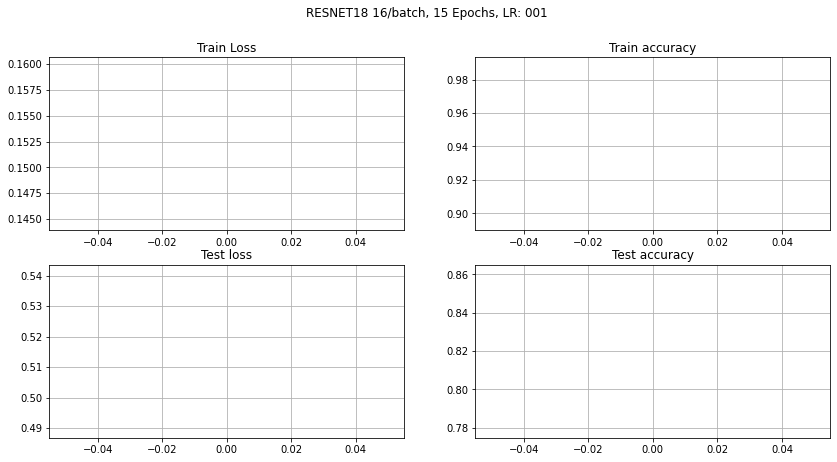

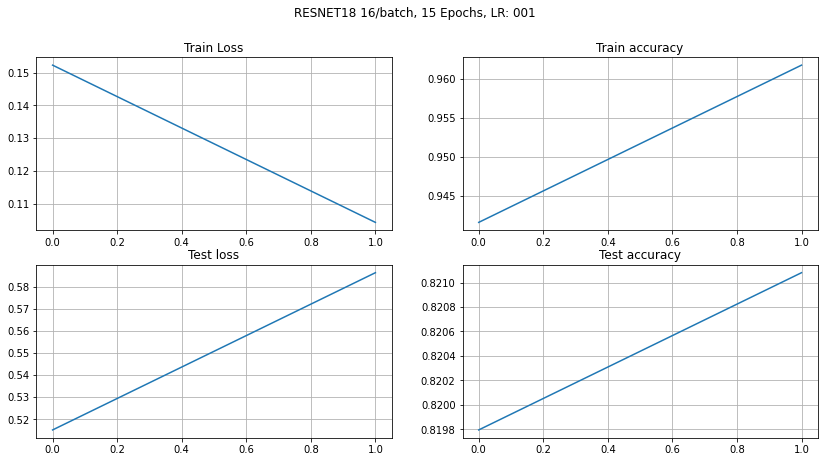

In [ ]:
done = False
# LRs = [0.015,0.01,0.1]
# its = [i for i in range(0,EPOCH,EPOCH//len(LRs))]

resnet = resnet18()
resnet.fc = nn.Linear(resnet.fc.in_features,2)
# resnet.fc.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.5, training=m.training)) # add a dropout layer
resnet.load_state_dict(torch.load("/content/drive/MyDrive/speedata/workspace/models/SpeedyNet18.pth"))
resnet = resnet.to(device)
print("RESNET18 INITIALIZED")
send().msg("RESNET18 INITIALIZED")

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
NAME = f"SpeedyNet18"

train_loss_vals = []
train_accuracy_vals = []
test_loss_vals = []
test_accuracy_vals = []

start = time.time()
for ep in range(EPOCH):
  messages = ''
  # if ep in its:

    # print(f"Setting LR to {LRs[its.index(ep)]}")
    # messages += f"Setting LR to {LRs[its.index(ep)]}" # for telegram

    # optimizer.param_groups[0]['lr'] = LRs[its.index(ep)]

  print(f"Epoch: {ep+1}/{EPOCH}\nLR: {optimizer.param_groups[0]['lr']}")
  messages += f"\nEpoch: {ep+1}/{EPOCH}\nLR: {optimizer.param_groups[0]['lr']}" # for telegram

  vals = epoch(resnet, dataloader["TEST"], dataloader["TRAIN"], loss_func, optimizer, device)
  train_loss_vals.append(vals[0])
  train_accuracy_vals.append(vals[1])
  test_loss_vals.append(vals[2])
  test_accuracy_vals.append(vals[3])

  print(f"Test Loss: {test_loss_vals[-1]:.3f} Test Accuracy: {test_accuracy_vals[-1]:.3f}")
  print(f"Train Loss: {train_loss_vals[-1]:.3f} Train Accuracy: {train_accuracy_vals[-1]:.3f}")
  messages += f"\nTest Loss: {test_loss_vals[-1]:.3f} Test Accuracy: {test_accuracy_vals[-1]:.3f}" # for telegram
  messages += f"\nTrain Loss: {train_loss_vals[-1]:.3f} Train Accuracy: {train_accuracy_vals[-1]:.3f}"
  print(f"Time: {(time.time()-start)/60:.2f} min(s)")
  messages += f"\nTime elapsed: {(time.time()-start)/60:.2f} min(s)" # for telegram
  
  if len(test_loss_vals)>2:
    if all(x > test_loss_vals[-1] for x in test_loss_vals[:-1]):
    # if test_loss_vals[-2]>test_loss_vals[-1]:
      model_name = os.path.join(FOLDERS["MODELS"],f"{NAME}.pth")
      
      print(f"Improvement detected. Saving the model\n")
      messages += f"\nImprovement detected. Saving the model" # for telegram

      torch.save(resnet.state_dict(),model_name)
  fig, a = plt.subplots(2,2, squeeze=False, figsize=(14,7))
  a[0][0].plot(train_loss_vals)
  a[0][0].set_title("Train Loss")
  a[0][0].grid(True)
  a[0][1].plot(train_accuracy_vals)
  a[0][1].set_title("Train accuracy")
  a[0][1].grid(True)
  a[1][0].plot(test_loss_vals)
  a[1][0].set_title("Test loss")
  a[1][0].grid(True)
  a[1][1].plot(test_accuracy_vals)
  a[1][1].set_title("Test accuracy")
  a[1][1].grid(True)
  fig.suptitle(f"RESNET18 {BATCH}/batch, {EPOCH} Epochs, LR: {str(optimizer.param_groups[0]['lr']).replace('0.','')}\n")
  # plt.show()
  performanceplot = f"PERFORMANCE.jpg"
  fig.savefig(performanceplot)
  send().pic(performanceplot)
  send().msg(messages)
  send().msg('———————————————————————')

print(f"Total time taken to train for {EPOCH} epochs on ResNet18: {(time.time()-start)/60:.2f} min(s)")
send().msg(f"Total time taken to train for {EPOCH} epochs ResNet18: {(time.time()-start)/60:.2f} min(s)")
print(f"{max(train_accuracy_vals)*100:.2f}% highest train accuracy at {train_accuracy_vals.index(max(train_accuracy_vals))} epoch and {max(test_accuracy_vals)*100:.2f}% highest test accuracy at {test_accuracy_vals.index(max(test_accuracy_vals))} epoch")
send().msg(f"{max(train_accuracy_vals)*100:.2f}% highest train accuracy at {train_accuracy_vals.index(max(train_accuracy_vals))} epoch and {max(test_accuracy_vals)*100:.2f}% highest test accuracy at {test_accuracy_vals.index(max(test_accuracy_vals))} epoch")
done = True

In [ ]:
fig, a = plt.subplots(2,2, squeeze=False, figsize=(14,7))
a[0][0].plot(train_loss_vals)
a[0][0].set_title("Train Loss")
a[0][0].grid(True)
a[0][1].plot(train_accuracy_vals)
a[0][1].set_title("Train accuracy")
a[0][1].grid(True)
a[1][0].plot(test_loss_vals)
a[1][0].set_title("Test loss")
a[1][0].grid(True)
a[1][1].plot(test_accuracy_vals)
a[1][1].set_title("Test accuracy")
a[1][1].grid(True)
fig.suptitle(f"RESNET18 {BATCH}/batch, {EPOCH} Epochs, LR: {str(optimizer.param_groups[0]['lr']).replace('0.','')}\n")
plt.show()
performanceplot = f"{FOLDERS['PERFORMANCE']}/{NAME}.jpg"
fig.savefig(performanceplot)
send().pic(performanceplot)

In [ ]:
%reset